In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from mapie.regression import MapieRegressor
from sklearn.base import BaseEstimator, RegressorMixin

# ---------------------------
# Setup: Load Model, Scaler, and Data
# ---------------------------
# Load the saved Keras model (using fold 1 as an example)
model = tf.keras.models.load_model("2Ddata_Transformer/transformer_model_fold1.keras")

# Load the StandardScaler
with open("2Ddata_Transformer/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Load fold 1 data (adjust file path if necessary)
with open("train_2d_fold1.pkl", "rb") as f:
    fold_data = pickle.load(f)

# Define label names (should match your training code)
LABEL_COLUMNS = ["Positive_Emotions", "Negative_Emotions", "Self_Esteem", "Meaning_in_Life", "Social_Support"]

# Determine indices for features and labels
columns = fold_data["columns"]
label_indices = [columns.index(col) for col in LABEL_COLUMNS]
feature_indices = [i for i in range(len(columns)) if i not in label_indices and columns[i] != "participant_id"]

# Process raw sequences (as in your training code)
X_raw = [np.array(seq[:, feature_indices], dtype=np.float32) for seq in fold_data["data"]]
y_raw = [np.array(seq[:, label_indices], dtype=np.float32) for seq in fold_data["data"]]

# Standardize: Flatten to fit the scaler then reassemble the sequences
X_flat = np.vstack(X_raw)
X_scaled = scaler.transform(X_flat)
X_fixed = []
start = 0
for seq in X_raw:
    length = len(seq)
    X_fixed.append(X_scaled[start:start + length])
    start += length

# ---------------------------
# Ensure consistent padding
# ---------------------------
# Get the expected sequence length from the model's input shape.
expected_seq_length = model.input_shape[1]  # Expected: 74 timesteps in your case

# Pad the sequences using the expected sequence length
X_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_fixed, maxlen=expected_seq_length, dtype="float32", padding="post"
)

# For labels, we use only the final timestep (as in your training code)
y_final = np.array([seq[-1] for seq in y_raw], dtype=np.float32)

2025-02-28 02:54:42.746783: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 02:54:42.793962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 02:54:42.793998: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 02:54:42.794037: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 02:54:42.804940: I tensorflow/core/platform/cpu_feature_g

In [3]:
# ---------------------------
# 1. SHAP Analysis using DeepExplainer
# ---------------------------
print("Starting SHAP analysis...")
# Select a background dataset (using the first 100 samples; adjust as needed)
background = X_padded[:100]
# Initialize the DeepExplainer with the background data
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem
explainer = shap.DeepExplainer(model, background)

# Explain the prediction for one sample (here the first sample)
sample = X_padded[0:1]
shap_values = explainer.shap_values(sample)

# If your model outputs multiple values (one per label), you can choose one output to inspect.
# Here we show a summary plot for the first output.
shap.summary_plot(shap_values[0], sample)
plt.title("SHAP Summary for Output 1")
plt.show()

Starting SHAP analysis...


StagingError: in user code:

    File "/home/jovyan/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 255, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_Einsum


157/157 [==============================] - 1s 7ms/step


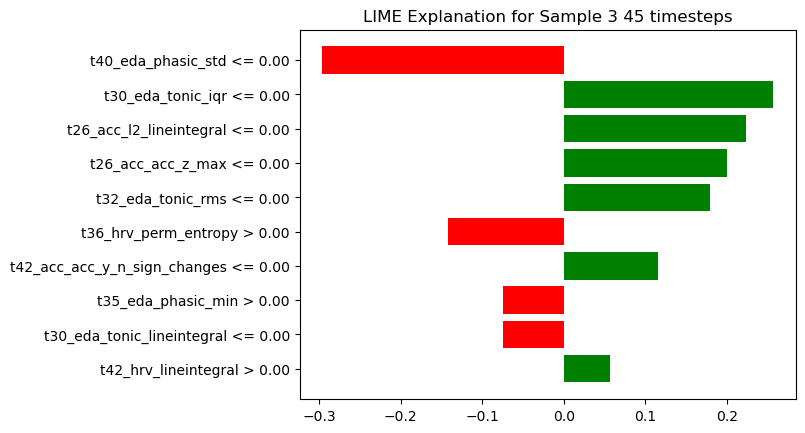

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import tensorflow as tf

# --- Assume these variables are already defined ---
# X_padded: padded data (n_samples, seq_len, n_features)
# model: your trained Keras model
# columns and feature_indices: as defined in your previous code

# Original full feature names (for all timesteps)
n_samples, seq_len, n_features = X_padded.shape
full_feature_names = []
actual_feature_names = [columns[idx] for idx in feature_indices]
for t in range(seq_len):
    for feat_name in actual_feature_names:
        full_feature_names.append(f"t{t}_{feat_name}")

# ----------- Truncate for a chosen sample -----------
sample_index = 3
sample_sequence = X_padded[sample_index]  # shape: (seq_len, n_features)

# Find the effective length: the number of timesteps before the first row that's all zeros.
non_padding = ~np.all(sample_sequence == 0, axis=1)
effective_length = int(np.sum(non_padding))
if effective_length == 0:
    effective_length = seq_len  # fallback if something goes wrong

# Create a truncated sample (only the non-padded timesteps)
truncated_sample = sample_sequence[:effective_length].flatten()

# Adjust the feature names for only these timesteps:
truncated_feature_names = full_feature_names[:effective_length * n_features]

# print(f"Truncated Feature Values for Sample {sample_index} (effective length = {effective_length}):")
# for fname, val in zip(truncated_feature_names, truncated_sample):
#     print(f"{fname}: {val}")

# ----------- Build a truncated background dataset -----------
# For LIME, we need a background dataset with the same feature dimension.
# Here, we truncate each sample to its first 'effective_length' timesteps.
X_truncated = X_padded[:, :effective_length, :].reshape(n_samples, effective_length * n_features)

# ----------- Define a custom prediction function -----------
def predict_fn_truncated(flat_X):
    """
    flat_X: array of shape (n, effective_length*n_features)
    We reshape each row into (effective_length, n_features),
    then pad it back to full sequence length, then predict.
    """
    samples = flat_X.reshape((-1, effective_length, n_features))
    # Pad back to the full length expected by the model.
    padded_samples = tf.keras.preprocessing.sequence.pad_sequences(
        samples, maxlen=seq_len, dtype="float32", padding="post"
    )
    preds = model.predict(padded_samples)
    return preds

# ----------- Initialize the LIME Explainer with the truncated data -----------
explainer_lime_trunc = lime.lime_tabular.LimeTabularExplainer(
    X_truncated,
    feature_names=truncated_feature_names,
    mode='regression'
)

# ----------- Run LIME on the truncated sample -----------
exp_trunc = explainer_lime_trunc.explain_instance(
    truncated_sample,
    predict_fn_truncated,
    num_features=10
)

fig = exp_trunc.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_index} {effective_length} timesteps")
plt.show()


7/7 [==============================] - 0s 7ms/step
Raw lower bound min: 0.31375861167907715
Clipped lower bound min: 0.31375861167907715
7/7 [==============================] - 0s 6ms/step
Raw lower bound min: -2.2761905193328857
Clipped lower bound min: 0.0
7/7 [==============================] - 0s 6ms/step
Raw lower bound min: 1.3531568050384521
Clipped lower bound min: 1.3531568050384521
7/7 [==============================] - 0s 6ms/step
Raw lower bound min: -0.4577927589416504
Clipped lower bound min: 0.0
7/7 [==============================] - 0s 4ms/step
Raw lower bound min: 0.0345606803894043
Clipped lower bound min: 0.0345606803894043


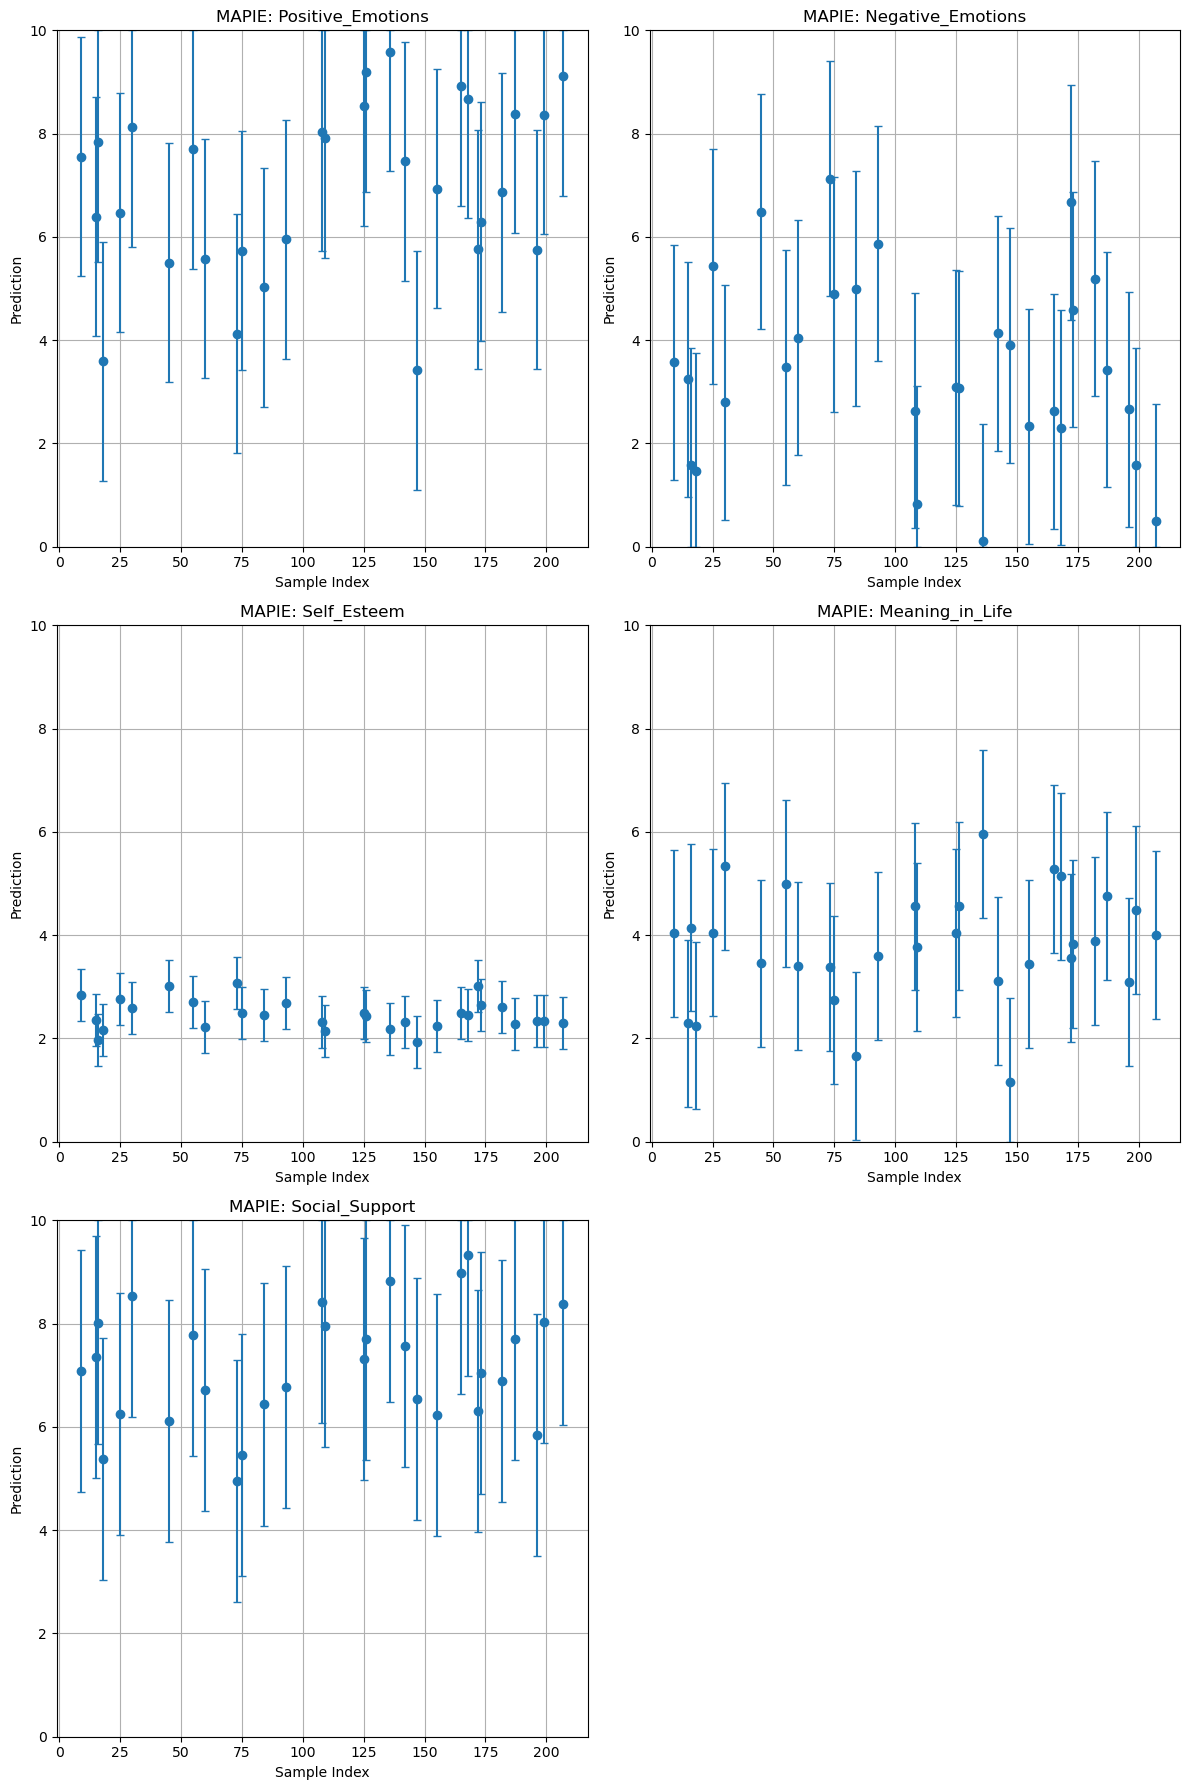

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.base import BaseEstimator, RegressorMixin
from mapie.regression import MapieRegressor

# Number of targets (e.g., 5 for your labels)
num_targets = y_final.shape[1]

# Select a random subset of sample indices (e.g., 30 samples)
np.random.seed(42)  # for reproducibility
sample_size = 30
n_samples = X_padded.shape[0]
sample_indices = np.random.choice(n_samples, size=sample_size, replace=False)

# Setup faceted plotting: 2 columns
n_cols = 2
n_rows = math.ceil(num_targets / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows), squeeze=False)

# Updated wrapper class: clip predictions to [0, 10] before selecting the target.
class KerasTargetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, target_idx, clip_min=0.0, clip_max=10.0):
        self.model = model
        self.target_idx = target_idx
        self.clip_min = clip_min
        self.clip_max = clip_max
    def fit(self, X, y):
        # Already trained, so no fitting needed.
        return self
    def predict(self, X):
        preds = self.model.predict(X)
        # Clip predictions to [0, 10]
        preds = np.clip(preds, self.clip_min, self.clip_max)
        return preds[:, self.target_idx]

# Loop over each target and plot predictions with prediction intervals
for t in range(num_targets):
    # Wrap the model for target t with clipping enforced.
    target_wrapper = KerasTargetWrapper(model, target_idx=t, clip_min=0.0, clip_max=10.0)
    
    # Initialize MAPIE for this target (using the "plus" method)
    mapie_target = MapieRegressor(target_wrapper, method="plus")
    
    # Extract the single-target ground truth (1D array)
    y_target = y_final[:, t]
    
    # Fit MAPIE on the entire dataset for calibration
    mapie_target.fit(X_padded, y_target)
    
    y_preds, y_intervals = mapie_target.predict(X_padded, alpha=0.1)

    raw_lower = y_intervals[:, 0, 0]
    raw_upper = y_intervals[:, 1, 0]
    print("Raw lower bound min:", np.min(raw_lower))

    # Enforce non-negative lower and an upper bound of 10:
    y_lower = np.maximum(raw_lower, 0)
    y_upper = np.minimum(raw_upper, 10)
    print("Clipped lower bound min:", np.min(y_lower))


    
    # Subset the predictions and intervals to the sampled indices
    y_preds_sample = y_preds[sample_indices].flatten()
    y_lower_sample = y_lower[sample_indices]
    y_upper_sample = y_upper[sample_indices]
    
    # Plot using error bars for the sampled indices
    ax = axes[t // n_cols][t % n_cols]
    ax.errorbar(
        sample_indices,
        y_preds_sample,
        yerr=[y_preds_sample - y_lower_sample, y_upper_sample - y_preds_sample],
        fmt='o', capsize=3, markersize=6, linestyle='None'
    )
    ax.set_title(f"MAPIE: {LABEL_COLUMNS[t]}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Prediction")
    ax.grid(True)
    ax.set_ylim(0, 10)  # enforce y-axis limits

# Hide any unused subplots
for j in range(num_targets, n_rows * n_cols):
    axes[j // n_cols][j % n_cols].set_visible(False)

plt.tight_layout()
plt.show()
